In [1]:
import pint
si = pint.UnitRegistry()

import numpy as np

from PyCloudParcel.parcel import parcel
from PyCloudParcel.phys import phys

%matplotlib inline
import matplotlib.pyplot as plt
si.setup_matplotlib()

ph = phys(si)

In [22]:
T0 = 300 * si.kelvin
p0 = 1000 * si.hectopascals
RH0 = .98

q0 = ph.eps/(p0 /RH0 /ph.pvs(T0) -1)


rho = p0 / ph.R(q0) / T0

rd = np.full((1,), .1) * si.micrometre
nd = np.full((1,), 500) / si.centimetre**3 / rho

w_avg = 100 * si.centimetre / si.second
t_hlf = 150 *si.second
w = lambda t: w_avg * np.pi/2 *np.sin(np.pi * t /t_hlf)

kp = .2

In [77]:
integ, sys = parcel(
        si = si,
        t = 2 * t_hlf,
        T0 = T0,
        q0 = q0,
        p0 = p0,
        w = w, 
        nd = nd, 
        rd = rd, 
        kp = kp,
        rtol = 1e-5
    )


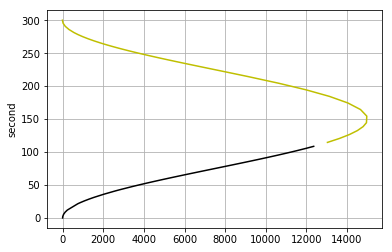

In [104]:
t = integ.t * sys.ix.t_unit
# plt.plot(w(t), t)
dt = np.diff(ph.mgn(t, si.second)) * si.second
h = np.concatenate([(0,), np.cumsum(dt*w(t[1:]-dt/2))])
# plt.plot(h,t)
plt.grid()
h1, h2 = np.split(h,2)
t1, t2 = np.split(t,2)
plt.plot(h1,t1, color = 'k')
plt.plot(h2,t2, color = 'y')


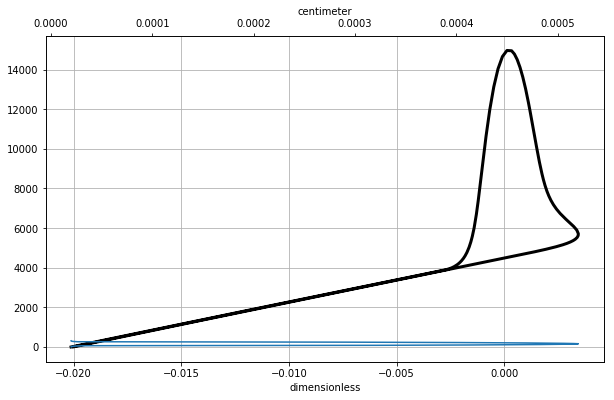

In [106]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twiny()

ix = sys.ix
fn = sys.fn
ph = sys.ph
    
p = integ.y[ix.p] * ix.p_unit
r = fn.r(integ.y[ix.x] * ix.x_unit)
t = t 
q = ph.q(sys.q1, nd, r)
    
if hasattr(ix, 'S'):
    S = integ.y[ix.S] * ix.S_unit
    T = ph.T(S,p,q)
elif hasattr(ix, 'T'):
    T = integ.y[ix.T] * ix.T_unit
    S = -1 + ph.RH(T, p, q) 
else:
    assert False
    
ax1.plot(S,h,color = 'k', linewidth=3)
for i in range(len(r)):
    ax2.plot(r[i],t)
ax1.grid()
ax2.xaxis.set_units(si.centimetre)